In [18]:
from helper_code import *
import numpy as np, os, sys, joblib
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns

torch.cuda.set_device(1) 
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/snomed_codes.csv",sep=",")[["Dx","SNOMEDCTCode"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMEDCTCode"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df

In [19]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
label_df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(label_df)


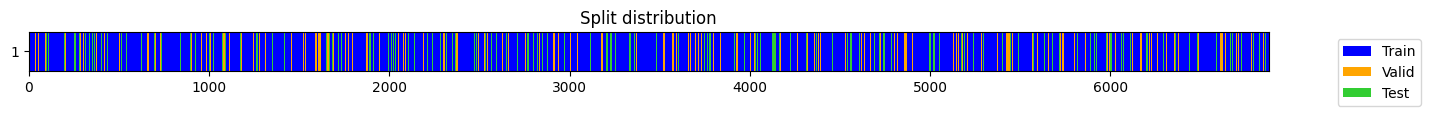

((#5503) [3730,369,1166,1104,1256,1925,1397,6851,5431,5658...],
 (#687) [3536,5567,3053,1591,268,2755,6308,2063,3139,3885...],
 (#687) [4921,3129,4389,2920,319,6726,55,1263,3608,2788...])

In [20]:
splits = get_splits(y.to_numpy(), valid_size=.1,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

In [21]:
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [ ]:
sf = 0.5
tfms = [None,TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
              tfs.Normalize(),
              tfs.Scale(scale_factor=0.5),
              tfs.BandPass(int(sf*500),3,45),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0) 
# reorganize y dataframe using dl's label/vocab mapping and count pos_weights
y = y[dls.vocab.o2i.keys()]
pos_weight = torch.tensor((len(y)-y.sum())/(y.sum()+1e-5))
metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=10,)
learn = Learner(dls, model, metrics=metrics, loss_func=nn.BCEWithLogitsLoss(),cbs=ShowGraph())
learn.fit_one_cycle(200, lr_max=0.004178080960048705)
learn.recorder.plot_metrics()

In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
import argparse
import glob
import itertools 

parser = argparse.ArgumentParser(description='experiment parameters')
# parser.add_argument('--batch_tfms',nargs="+",default=["sc","n", "bp"],help="input list of ints ->n:normalize sc:scale bp:bandpass sh:shift")
# parser.add_argument('--norm_type',default="minmax",help="normalization function (minmax, maxdiv,zscore,median,deci_scale)")
parser.add_argument('--max_len',default=8000,type=int,help="max_len of ecgs")
# parser.add_argument('--HP',default=1,type=int,help="high pass filter")
# parser.add_argument('--LP',default=50,type=int,help="low pass filter")
# parser.add_argument('--scale',type=float,default=0.5,help="down/upsample scale")
# parser.add_argument('--scale_type',default="nearest-exact",help="nearest / nearest-exact / area")
parser.add_argument('--gpu_num',default=1,type=int,help="gpu device")
parser.add_argument('--cv_num',default=0,type=int,help="cv num")
parser.add_argument('--arch',default="inception",help="inception or minirocket")
parser.add_argument('--dataset',default="CPSC2018",help="CPSC2018 or chapmanshaoxing or PTBXL")
# parser.add_argument('--cv_range',default=[0,1,2,3,4],nargs="+",type=int,help="folds to train")

args = parser.parse_args(args=[])

# print("pre-processing funcs: ",args.batch_tfms)
# print("gpu num :",args.gpu_num)
# print("scaling :",args.scale)
# print("training folds:",args.cv_range)
# print("max len:",args.max_len)
# print("dataset",args.dataset)

torch.cuda.set_device(args.gpu_num)
# norm_type = args.norm_type
max_len = 4000
# sf = args.scale
# LP = args.LP
# HP = args.HP
# scale_type = args.scale_type
# cv_range = args.cv_range
cv_num = args.cv_num
architecture = args.arch
DATASET_ID = args.dataset
# transforms = args.batch_tfms
# batch_tfms = []



/home/asalimi/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define the possible combinations
csv_path = "models/bandpassing/csvs/"
num_trials = 20
sc_values = [0.1, 0.25,0.5,0.75]
bp_values = [(1,30),(1,50),(1,100)]
norm_values = ["min_max"]
# experiment_name = "%s_%s_%s_%s_%s_%s_%s"%(architecture,DATASET_ID,"-".join(processing_type),sf,HP,LP,norm_type)

# glob.glob(csv_path+"/"+experiment_name+"*")
# experiment_name
# possible sequence combinations
funcs = ["bp","sc","n"]
func_sequences = []
for i,f in enumerate(funcs):
    cfuncs = funcs.copy()
    cfuncs.pop(i)
    func_sequences.extend(list(zip([f]*len(cfuncs),cfuncs)))
# processing_type = '-'.join([x for x in transforms])
# processing_type = func_sequences[0]
# print(processing_type)

In [14]:
# all possible csv names
experiment_names = []
for processing_type in func_sequences:
    bp = "bp" in processing_type
    n = "n" in processing_type
    sc = "sc" in processing_type
    
    if bp and sc:
        for pair in itertools.product(bp_values, sc_values):
            HP,LP = pair[0][0],pair[0][1]
            sf = pair[1]
            experiment_names.append("%s_%s_%s_%s_%s_%s_%s"%
                        (architecture,DATASET_ID,"-".join(processing_type),sf,HP,LP,"None"))
    if bp and n:
        for pair in itertools.product(bp_values, norm_values):
            HP,LP = pair[0][0],pair[0][1]
            norm_type = pair[1]
            experiment_names.append("%s_%s_%s_%s_%s_%s_%s"%(architecture,DATASET_ID,"-".join(processing_type),None,HP,LP,"minmax"))
    if sc and n:
        for pair in itertools.product(sc_values, norm_values):
            sf = pair[0]
            norm_type = pair[1]
            experiment_names.append("%s_%s_%s_%s_%s_%s_%s"%(architecture,DATASET_ID,"-".join(processing_type),sf,None,None,"minmax"))
         
for p in experiment_names:
    print(p)

inception_CPSC2018_bp-sc_0.1_1_30_None
inception_CPSC2018_bp-sc_0.25_1_30_None
inception_CPSC2018_bp-sc_0.5_1_30_None
inception_CPSC2018_bp-sc_0.75_1_30_None
inception_CPSC2018_bp-sc_0.1_1_50_None
inception_CPSC2018_bp-sc_0.25_1_50_None
inception_CPSC2018_bp-sc_0.5_1_50_None
inception_CPSC2018_bp-sc_0.75_1_50_None
inception_CPSC2018_bp-sc_0.1_1_100_None
inception_CPSC2018_bp-sc_0.25_1_100_None
inception_CPSC2018_bp-sc_0.5_1_100_None
inception_CPSC2018_bp-sc_0.75_1_100_None
inception_CPSC2018_bp-n_None_1_30_minmax
inception_CPSC2018_bp-n_None_1_50_minmax
inception_CPSC2018_bp-n_None_1_100_minmax
inception_CPSC2018_sc-bp_0.1_1_30_None
inception_CPSC2018_sc-bp_0.25_1_30_None
inception_CPSC2018_sc-bp_0.5_1_30_None
inception_CPSC2018_sc-bp_0.75_1_30_None
inception_CPSC2018_sc-bp_0.1_1_50_None
inception_CPSC2018_sc-bp_0.25_1_50_None
inception_CPSC2018_sc-bp_0.5_1_50_None
inception_CPSC2018_sc-bp_0.75_1_50_None
inception_CPSC2018_sc-bp_0.1_1_100_None
inception_CPSC2018_sc-bp_0.25_1_100_None
i

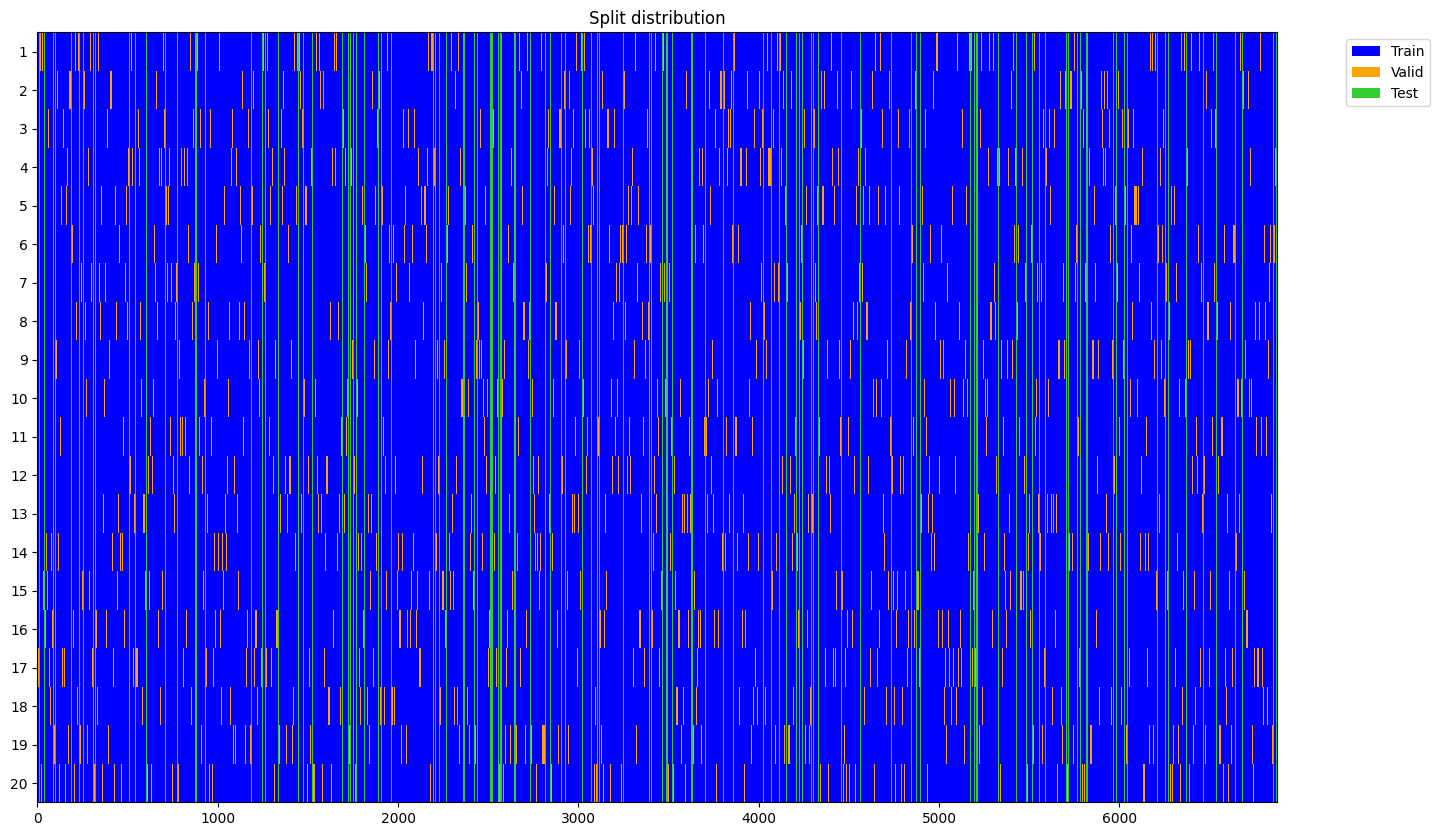

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, '1st degree av block': 722, 'premature atrial contraction': 616}


In [4]:
DATASET_NAME = "WFDB_%s_signitured"%DATASET_ID
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
y = y[y.columns[y.sum()>0.05*len(y)] ]

cv_splits = get_splits(y.to_numpy(), n_splits = 20, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))
tfms  = [None, TSMultiLabelClassification()]

In [22]:
def float_if_valid(var):
    if var != "None":
        return np.float(var)
    else:
        return var

In [38]:
!ls models/sequences/csvs/

inception_CPSC2018_bp-n_None_1_100_minmax_1.csv
inception_CPSC2018_bp-n_None_1_30_minmax_1.csv
inception_CPSC2018_bp-n_None_1_50_minmax_1.csv
inception_CPSC2018_bp-sc_0.1_1_100_None_0.csv
inception_CPSC2018_bp-sc_0.1_1_100_None_1.csv
inception_CPSC2018_bp-sc_0.1_1_30_None_0.csv
inception_CPSC2018_bp-sc_0.1_1_30_None_1.csv
inception_CPSC2018_bp-sc_0.1_1_30_None_2.csv
inception_CPSC2018_bp-sc_0.1_1_50_None_0.csv
inception_CPSC2018_bp-sc_0.1_1_50_None_1.csv
inception_CPSC2018_bp-sc_0.25_1_100_None_0.csv
inception_CPSC2018_bp-sc_0.25_1_100_None_1.csv
inception_CPSC2018_bp-sc_0.25_1_30_None_0.csv
inception_CPSC2018_bp-sc_0.25_1_30_None_1.csv
inception_CPSC2018_bp-sc_0.25_1_30_None_2.csv
inception_CPSC2018_bp-sc_0.25_1_50_None_0.csv
inception_CPSC2018_bp-sc_0.25_1_50_None_1.csv
inception_CPSC2018_bp-sc_0.5_1_100_None_0.csv
inception_CPSC2018_bp-sc_0.5_1_100_None_1.csv
inception_CPSC2018_bp-sc_0.5_1_30_None_0.csv
inception_CPSC2018_bp-sc_0.5_1_30_None_1.csv
inception_CPSC2018_bp-sc_0.5_1_50_N

In [ ]:
for experiment_name in experiment_names:
    ''' getting the function vars out of the experiment file name'''
    print(experiment_name)
    vars = experiment_name.split("_")
    processing_type = vars[2].split("-")
    sf = float_if_valid(vars[3])
    HP,LP = np.float(vars[4]),np.float(vars[5])
    norm_type = vars[6]
    print("processing type: %s \n hp-lp:%s,%s \n scale factor:%s \n norm_type:%s"%
          (processing_type,HP,LP,sf,norm_type))
    batch_tfms = []
    for t in processing_type:
        if t == "sc":
            batch_tfms.append(tfs.Scale(scale_factor=sf,mode="nearest-exact"))
        if t == "n":
            batch_tfms.append(tfs.NormMinMax())
        if t == "bp":
            if sc == "None": # if there's no scaling, then we scale by 0.5 for faster processing
                batch_tfms.append(tfs.Scale(scale_factor=0.5,mode="nearest-exact"))
                batch_tfms.append(tfs.BandPass(int(0.5*500),low_cut=LP, high_cut=HP,leads=12,))
            else:
                 batch_tfms.append(tfs.BandPass(int(0.5*500),low_cut=LP, high_cut=HP,leads=12,))
    print("transforms:\n",[x.name for x in batch_tfms])
    
    csv_path = "models/sequences/csvs/%s_%s.csv"%(experiment_name,cv_num)  
    
    
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[precision_multi, recall_multi, specificity_multi, F1_multi]
    if architecture == "inception":
        model = InceptionTimePlus(dls.vars, dls.c, dls.len,)
    elif architecture == "minirocket":
        model = MiniRocketPlus(dls.vars, dls.c,dls.len)
    elif architecture == "xresnet1d101":
        model = xresnet1d101(dls.vars, dls.c)
    # try : loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt())
    
    learn = Learner(dls, model, metrics=metrics,
    #                     opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=6.614e-07),
                    cbs=[fastai.callback.all.SaveModelCallback(
                        monitor="F1_multi",fname="%s_%s"%(experiment_name ,cv_num)),
                        fastai.callback.all.EarlyStoppingCallback(monitor='F1_multi', min_delta=0.005, patience=50)
                        ],
                    model_dir="models/sequences/")
    
    learn.fit_one_cycle(2, lr_max=0.01,)
    # now test it on test set
    learn.load("%s_%s"%(experiment_name ,cv_num))
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    y_pred = (valid_preds>0)
    y_test = valid_targets
    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    df = pd.DataFrame(report).reset_index()
    df.to_csv(csv_path,index=False)
    
    del model,learn
    gc.collect()
    torch.cuda.empty_cache()
    # break ### remove break 

# processing_type